# Load Tools

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import random
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Flatten, Conv2D, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters

In [2]:
path = "myData"
labelfile = "labels.csv"
batch_size_val = 50
steps_per_epoch_val = 2000
epochs_val = 10
imageDimensions = (32, 32, 3)
testRatio = 0.2
validationRation = 0.2

# Importing of the Image

In [3]:
count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:", len(myList))
noOfClasses = len(myList)
print("Importing Classes........")
for x in range(0, len(myList)):
    myPicList = os.listdir(path + "/" + str(count))
    for y in myPicList:
        curImg = cv2.imread(path + "/" + str(count) + "/" + y)
        images.append(curImg)
        classNo.append(count)
    print(count, end = " ")
    count += 1

# Converting In array
images = np.array(images)
classNo = np.array(classNo)

Total Classes Detected: 43
Importing Classes........
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 

# Splitting Data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size = testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(images, classNo, test_size = validationRation)

In [5]:
# X_train =  Array of Images to Train
# y_train = Corresponding Class ID

# To Check If Number Of Images Matches To Number Of Labels For Each Data Set

In [6]:
print("Data Shapes")
print("Train",end = "");print(X_train.shape,y_train.shape)
print("Validation",end = "");print(X_validation.shape,y_validation.shape)
print("Test",end = "");print(X_test.shape,y_test.shape)
assert(X_train.shape[0]==y_train.shape[0]), "The number of images in not equal to the number of lables in training set"
assert(X_validation.shape[0]==y_validation.shape[0]), "The number of images in not equal to the number of lables in validation set"
assert(X_test.shape[0]==y_test.shape[0]), "The number of images in not equal to the number of lables in test set"
assert(X_train.shape[1:]==(imageDimensions))," The dimesions of the Training images are wrong "
assert(X_validation.shape[1:]==(imageDimensions))," The dimesionas of the Validation images are wrong "
assert(X_test.shape[1:]==(imageDimensions))," The dimesionas of the Test images are wrong"


Data Shapes
Train(27839, 32, 32, 3) (27839,)
Validation(6960, 32, 32, 3) (6960,)
Test(6960, 32, 32, 3) (6960,)


# Read CSV File 

In [7]:
data = pd.read_csv("labels.csv")
print("data shape", data.shape, type(data))

data shape (43, 2) <class 'pandas.core.frame.DataFrame'>


# Display Some Samples Images of All Classes

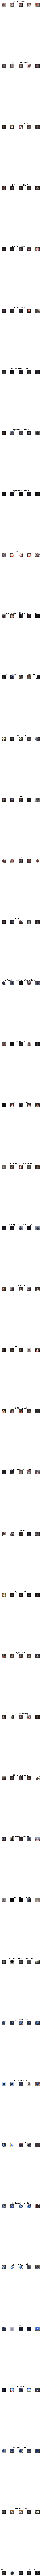

In [8]:
num_of_samples = []
cols = 5
num_classes = noOfClasses
fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (5, 300))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected) -1), :, :], 
                         cmap = plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "_" + row["Name"])
            num_of_samples.append(len(x_selected))
        

# Display a BAR chart showing NO of Samples for each Category

[147, 1582, 1592, 993, 1424, 1346, 292, 1020, 1012, 1043, 1433, 944, 1504, 1545, 550, 421, 283, 798, 871, 153, 233, 220, 263, 378, 195, 1077, 430, 158, 388, 192, 314, 549, 170, 469, 284, 893, 249, 134, 1515, 207, 239, 161, 168]


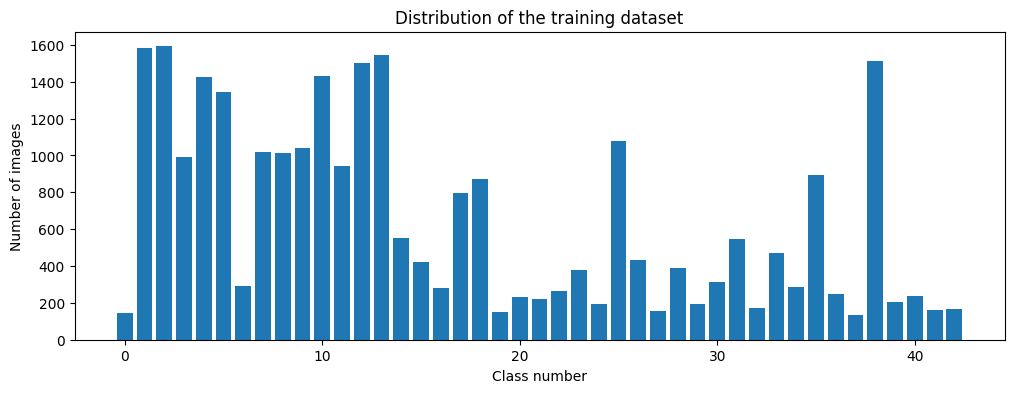

In [9]:
print(num_of_samples)
plt.figure(figsize = (12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()


# Preprocessing The Images

In [10]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

def preprocessing(img):
    img = grayscale(img)   # CONVERT TO GRAYSCALE
    img = equalize(img)      # STANDARDIZE THE LIGHTING IN AN IMAGE
    img = img/255            # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0

    return img

In [11]:
X_train = np.array(list(map(preprocessing, X_train))) # TO ITERATE AND PREPROCESS ALL IMAGES
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))
# cv2.imshow("GrayScale Images", X_train[random.randint(0, len(X_train)-1)]) # TO CHECK IF THE TRAINING IS DONE PROPERLY
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# ADD A DEPTH OF I

In [12]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2], 1)

# AUGMENTATION OF IMAGES: TO MAKEIT MORE GENERIC

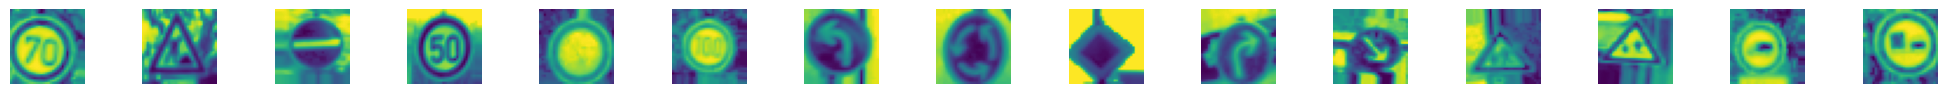

In [18]:
dataGen = ImageDataGenerator(
    width_shift_range = 0.1,        # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
    height_shift_range = 0.1,
    zoom_range = 0.2,               # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
    shear_range = 0.1,              # MAGNITUDE OF SHEAR ANGLE
    rotation_range = 10             # DEGREES
)

dataGen.fit(X_train)
batches = dataGen.flow(X_train, y_train, batch_size = 20)   # REQUESTING DATA GENRATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREAED EACH TIME ITS CALLED
X_batch, y_batch = next(batches)

# TO SHOW AGMENTED IMAGE SAMPLES
fig,axs = plt.subplots(1, 15, figsize = (20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimensions[0], imageDimensions[1]))
    axs[i].axis("off")
    
plt.show()

In [19]:
y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)

# CONVOLUTION NEURAL NETWORK MODEL

In [27]:
model = Sequential()

# FIRST LAYER

model.add((Conv2D(filters = 60, kernel_size = (5,5), input_shape = (imageDimensions[0],imageDimensions[1], 1), activation = "relu")))
model.add((Conv2D(filters = 60, kernel_size = (5,5), activation = "relu")))
model.add((MaxPooling2D(pool_size = (2,2))))

# SECOND LAYER

model.add((Conv2D(filters = 60//2, kernel_size = (3,3), activation = "relu")))
model.add((Conv2D(filters = 60//2, kernel_size = (3,3), activation = "relu")))
model.add((MaxPooling2D(pool_size = (2,2))))
model.add(Dropout(0.5))


# FULLY CONNECTED LAYER

model.add((Flatten()))
model.add((Dense(units = 500, activation = "relu")))
model.add((Dropout(0.5)))

# OUTPUT LAYER

model.add((Dense(noOfClasses, activation = "softmax")))


# COMPILE MODEL

model.compile(Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()           

C:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 28, 28, 60)          │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 24, 24, 60)          │          90,060 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 12, 12, 60)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 10, 10, 30)          │          16,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 8, 8, 30)            │           8,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 4, 4, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 4, 4, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 43)                  │          21,543 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

# TRAIN MODEL

In [30]:
history = model.fit(dataGen.flow(X_train, y_train, batch_size = batch_size_val),
          steps_per_epoch = steps_per_epoch_val,
          epochs = epochs_val,
          validation_data = (X_validation,y_validation),
          shuffle = 1)

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 110s 55ms/step - accuracy: 0.9212 - loss: 0.2476 - val_accuracy: 0.9921 - val_loss: 0.0291
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 79s 39ms/step - accuracy: 0.9306 - loss: 0.2256 - val_accuracy: 0.9922 - val_loss: 0.0306
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - accuracy: 0.9346 - loss: 0.2150 - val_accuracy: 0.9918 - val_loss: 0.0314
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 48s 24ms/step - accuracy: 0.9361 - loss: 0.2076 - val_accuracy: 0.9892 - val_loss: 0.0334
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 49s 25ms/step - accuracy: 0.9394 - loss: 0.1950 - val_accuracy: 0.9908 - val_loss: 0.0282
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 50s 25ms/step - accuracy: 0.9426 - loss: 0.1894 - val_accuracy: 0.9932 - val_loss: 0.0262
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 51s 25ms/step - accuracy: 0.9469 - loss: 0.1767 - val_accuracy: 0.9908 - val_loss: 0.0292
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 52s 26ms/step - accuracy: 0.9466 

# PLOT

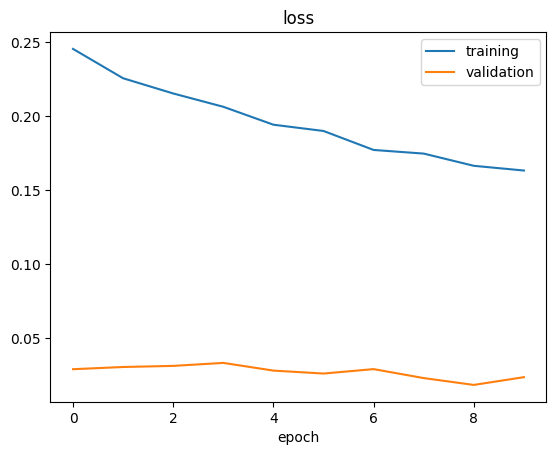

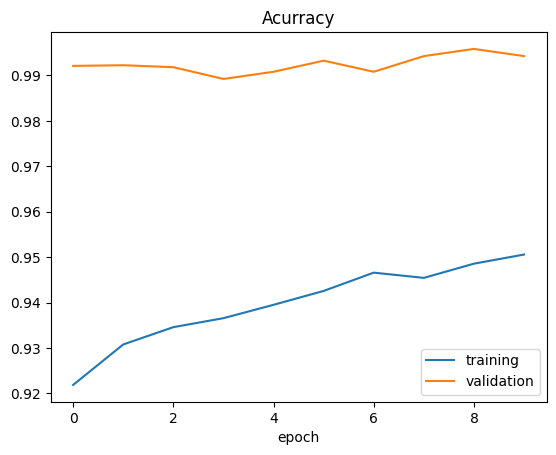

Test Score: 0.0155295105651021
Test Accuracy: 0.9958333373069763


In [31]:

plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score =model.evaluate(X_test,y_test,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])

In [33]:
import joblib 

In [34]:
joblib.dump(model, "TrafficSign_model.joblib")

['TrafficSign_model.joblib']